<a href="https://colab.research.google.com/github/harshitha14-cyber/MLProject/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib

In [44]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


In [45]:
df1 = pd.read_csv("test.csv")
df2 = pd.read_csv("train.csv")

df = pd.concat([df1,df2],ignore_index=True)

In [46]:
selected_columns = [
    "Gender",
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History",
    "Property_Area",
    "Loan_Status"
]
df = df[selected_columns]

In [47]:
df["Risk"] = df["Loan_Status"].map({"Y": 0, "N": 1})
df.drop("Loan_Status", axis=1, inplace=True)

In [48]:
# Feature Engineering

df["Total_Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
df["Debt_to_Income"] = df["LoanAmount"] / df["Total_Income"]

df["Age_Group"] = np.random.choice(["Young", "Adult", "Senior"], len(df)) # This dataset doesn't have age column

In [49]:
# handling Missing values

for col in df.columns:
  if df[col].dtype == "object":
    df[col].fillna(df[col].mode()[0], inplace=True)
  else:
    df[col].fillna(df[col].median(), inplace=True)

/tmp/ipython-input-375380809.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-375380809.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

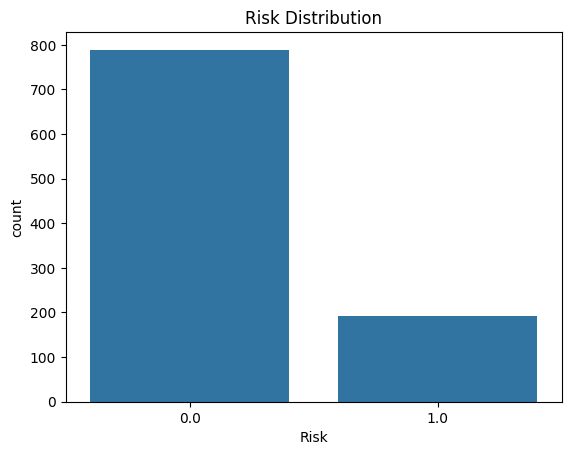

In [50]:
# EDA
# Class Distribution

sns.countplot(x="Risk", data=df)
plt.title("Risk Distribution")
plt.show()

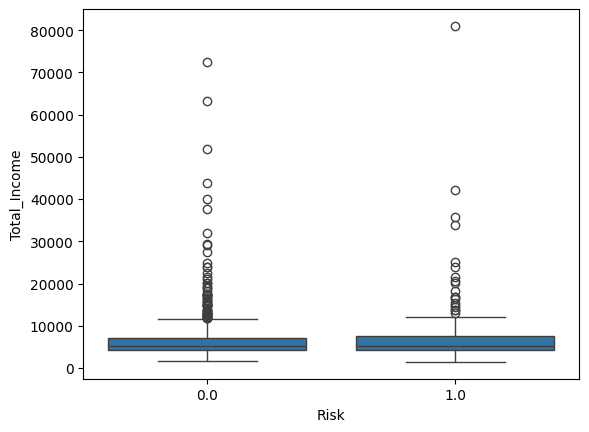

In [51]:
# Income Vs Risk boxplot

sns.boxplot(x="Risk", y="Total_Income", data=df)
plt.show()

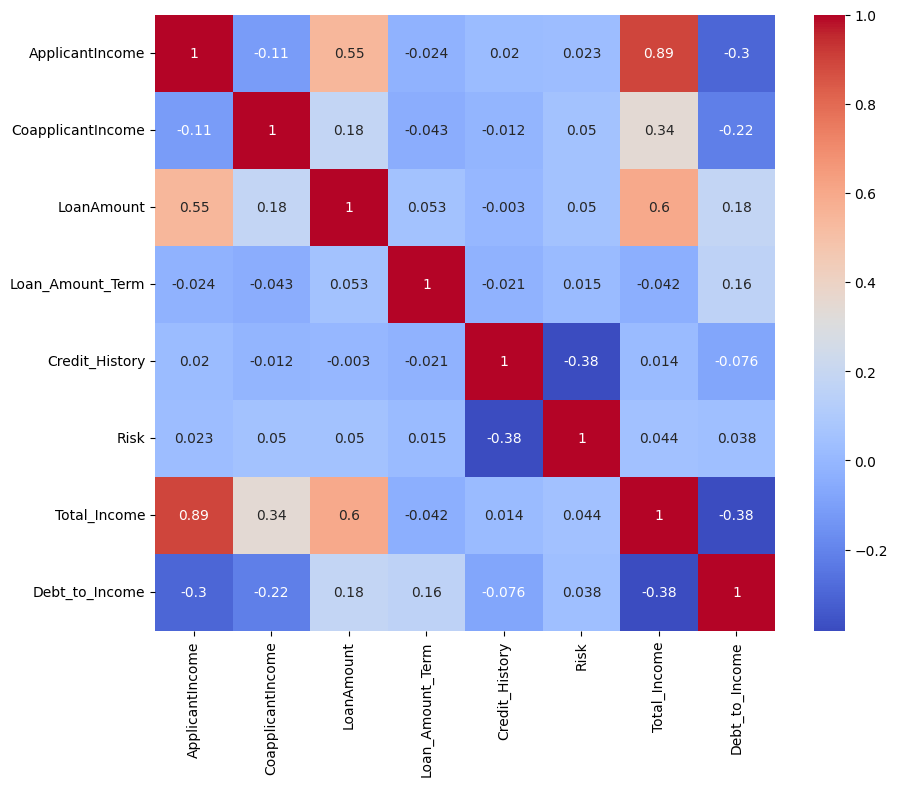

In [52]:
# Correlation heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.show()

In [53]:
# features and target split
X = df.drop("Risk", axis=1)
y = df["Risk"]

In [54]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [56]:
!pip install xgboost

In [57]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}

best_model = None
best_auc = 0

for name, model in models.items():

    pipeline = ImbPipeline([
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_prob)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", auc)

    if auc > best_auc:
        best_auc = auc
        best_model = pipeline


Logistic Regression
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81       158
         1.0       0.35      0.56      0.44        39

    accuracy                           0.71       197
   macro avg       0.61      0.66      0.62       197
weighted avg       0.77      0.71      0.73       197

ROC-AUC: 0.7140538786108406

Random Forest
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       158
         1.0       0.54      0.33      0.41        39

    accuracy                           0.81       197
   macro avg       0.70      0.63      0.65       197
weighted avg       0.79      0.81      0.79       197

ROC-AUC: 0.7438331710483609

Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       158
         1.0       0.52      0.36      0.42        39

    accuracy                           0.81       197
   macro avg     

In [64]:
param_dist = {
    "model__n_estimators": [100, 150, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [1, 5],
    "model__scale_pos_weight": [1, 2, 4]
}

fast_xgb = XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

best_model.named_steps["model"] = fast_xgb

param_dist = {
    "model__n_estimators": [80, 120],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4],
    "model__scale_pos_weight": [1, 2]
}

random_search = RandomizedSearchCV(
    best_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [66]:
print("Best Parameters Found:")
for k, v in random_search.best_params_.items():
    print(k, ":", v)

Best Parameters Found:
model__scale_pos_weight : 2
model__n_estimators : 80
model__max_depth : 4
model__learning_rate : 0.05


In [67]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Final ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       158
         1.0       0.35      0.51      0.42        39

    accuracy                           0.72       197
   macro avg       0.61      0.64      0.61       197
weighted avg       0.76      0.72      0.73       197

Final ROC-AUC: 0.7289840960727038


In [68]:
joblib.dump(best_model, "credit_risk_model.pkl")

['credit_risk_model.pkl']

In [69]:
from google.colab import files
files.download("credit_risk_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>